# Final Year Project - Intelligent Health Monitoring System
#### by: Koo Chia Meng, A0165275Y

### DATA ANALYSIS

### Correlation in Health Improvements:
### Number of Steps & Very Active Duration VS RHR

The following will be done in this Notebook:
1. Exploring the correlation between the parameters given by health trackers and improvement in health.
    - The increase in Activity (Steps and Very Active Duration) is correlated with the increase in Heart Health (lower RHR)?
        
2. How to justify Health improvements:
    - Decrease / increase in certain heatlth indicators as used in multiple health studies.

### Importing both person data

In [4]:
#Import relevant Dependencies

import datetime
import time
import pandas as pd # Pandas Version 1.0.5
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy import stats as sps
import sklearn.linear_model as lm
import seaborn as sns # use for visualising
import os

In [5]:
%run FYP_SUBJECTS_CLASS.ipynb # line needed to reuse the SUBJECT class created for OOP

### Loading Subjects from PICKLE

In [6]:
current_directory = os.getcwd()
folder = "PERSON1" # CHANGE HERE
file = "PERSON1_DATA_31JUL.pickle" # CHANGE HERE
f_path = os.path.join(current_directory,folder,file)
                      
with open(f_path,'rb') as f:
    PERSON1 = pickle.load(file=f)

In [7]:
PERSON1.profile

{'age': 28, 'gender': 'MALE', 'height': 170.0, 'weight': 75.0}

In [8]:
current_directory = os.getcwd()
folder = "PERSON2" # CHANGE HERE
file = "PERSON2_DATA_31JUL.pickle" # CHANGE HERE
f_path = os.path.join(current_directory,folder,file)
                      
with open(f_path,'rb') as f:
    PERSON2 = pickle.load(file=f)

In [9]:
PERSON2.profile

{'age': 27, 'gender': 'MALE', 'height': 176.0, 'weight': 65.0}

### Loading Previously Processed DFs from PICKLE

In [10]:
current_directory = os.getcwd()
folder = os.path.join("PERSON1","31JUL") # CHANGE HERE
folder_path = os.path.join(current_directory,folder)

# LOAD FROM PICKLE:

unpickle = {}
unpickle_list = [
                # Daily Resting Heart Rate DF:
                'df_resting_hr',

                # Daily Heart Rate Zones (HR Activities) DF:
                'df_hr_calories',

                # Intra-day Heart Rate DF:
                'df_intraday_hr',

                # Sleep Durations DF
                'df_sleep_durations',

                # Detailed intra Sleep Stages DF
                'df_intra_sleep_stage',

                # Daily Step activities DF:
                'df_activity_steps',
    
                # Derived HRV Stats DFs:
                'df_hrv_stats_full_day',
                'df_hrv_stats_AM',
                'df_hrv_stats_PM'
]

for i in unpickle_list:
    file = os.path.join(folder_path, str(i) + '.pickle')
    with open(file,'rb') as f:
        unpickle[i] = pickle.load(file=f)

PERSON1.df_resting_hr = unpickle['df_resting_hr']
PERSON1.df_hr_calories = unpickle['df_hr_calories']
PERSON1.df_intraday_hr = unpickle['df_intraday_hr']
PERSON1.df_sleep_durations = unpickle['df_sleep_durations']
PERSON1.df_intra_sleep_stage = unpickle['df_intra_sleep_stage']
PERSON1.df_activity_steps = unpickle['df_activity_steps']
PERSON1.df_hrv_stats_full_day = unpickle['df_hrv_stats_full_day']
PERSON1.df_hrv_stats_AM = unpickle['df_hrv_stats_AM']
PERSON1.df_hrv_stats_PM = unpickle['df_hrv_stats_PM']


In [11]:
current_directory = os.getcwd()
folder = os.path.join("PERSON2","31JUL") # CHANGE HERE
folder_path = os.path.join(current_directory,folder)

# LOAD FROM PICKLE:

unpickle = {}
unpickle_list = [
                # Daily Resting Heart Rate DF:
                'df_resting_hr',

                # Daily Heart Rate Zones (HR Activities) DF:
                'df_hr_calories',

                # Intra-day Heart Rate DF:
                'df_intraday_hr',

                # Sleep Durations DF
                'df_sleep_durations',

                # Detailed intra Sleep Stages DF
                'df_intra_sleep_stage',

                # Daily Step activities DF:
                'df_activity_steps',
    
                # Derived HRV Stats DFs:
                'df_hrv_stats_full_day',
                'df_hrv_stats_AM',
                'df_hrv_stats_PM'
]

for i in unpickle_list:
    file = os.path.join(folder_path, str(i) + '.pickle')
    with open(file,'rb') as f:
        unpickle[i] = pickle.load(file=f)

PERSON2.df_resting_hr = unpickle['df_resting_hr']
PERSON2.df_hr_calories = unpickle['df_hr_calories']
PERSON2.df_intraday_hr = unpickle['df_intraday_hr']
PERSON2.df_sleep_durations = unpickle['df_sleep_durations']
PERSON2.df_intra_sleep_stage = unpickle['df_intra_sleep_stage']
PERSON2.df_activity_steps = unpickle['df_activity_steps']
PERSON2.df_hrv_stats_full_day = unpickle['df_hrv_stats_full_day']
PERSON2.df_hrv_stats_AM = unpickle['df_hrv_stats_AM']
PERSON2.df_hrv_stats_PM = unpickle['df_hrv_stats_PM']

In [12]:
PERSON_LIST = [PERSON1,PERSON2] # Declare a list of person to create

### EMPIRICAL CUMULATIVE DISTRIBUTION FUNCTION
This is use together with scatter plotting to view the cumulative distribution function

In [13]:
# Referenced from DATACAMP.com:

def ecdf(data):
    """FUNCTION TO GENERATE ECDF, REUTRNS X, Y"""
    
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF, actual value: x
    x = np.sort(data)

    # y-data for the ECDF, Cumulative Probability: y
    y = np.arange(1, n+1) / n

    return x, y

### BOOSTRAP REPLICATES FUNCTION
This is to generate more samples to find more a better estimate of a statistical value (like mean) base on existing datasets.
SD of the bootstrap sample will give the Standard Error, (MEAN +- SD). Confidence Interval, (CI) for the statistical value can also be obtained.

In [14]:
# Referenced from DATACAMP.com:

def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = func(np.random.choice(data, size=len(data)))

    return bs_replicates

### PERMUTATION REPLICATES FUNCTION

This is used for explore relations and prove NULL HYPOTHESIS. Permutation replicate combines two set of data and then selects records at random. If both data set is similar, their extreme values will be similar. 

In [15]:
# Referenced from DATACAMP.com:

def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

In [16]:
# Referenced from DATACAMP.com:

def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1,data_2)
        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1,perm_sample_2)

    return perm_replicates

### CORRELATION PLOTS

### Steps VS RHR Values

Hypothesis: As the number of steps increase, Heart becomes healthier, RHR decreases.

#### Using Z-Score to Find Outliers

In [17]:
# Z Score can be used to find outliers if the data is a normal distribution:
# if z-score value is more than 3, the point is most likely an outlier.
# Zscore tells us how far away (in the ratio of SD) the record is away from the mean.

list_plot = [] # define empt list to store DF for plotting later.

for i, subject in enumerate(PERSON_LIST): # applying the same steps for PERSON1 and PERSON2.
    # INPUT X & Y SERIES:
    x_plot = subject.df_activity_steps.step_count.copy()
    y_plot = subject.df_resting_hr.restingHeartRate.copy()

    # Finding Z-Score & Setting Date as index:
    x_plot = pd.concat([x_plot.reset_index(),pd.Series(sps.zscore(x_plot))],axis=1)
    x_plot = x_plot.rename(columns={0:'z_score'}).set_index('dateTime')

    y_plot = pd.concat([y_plot.reset_index(),pd.Series(sps.zscore(y_plot))],axis=1)
    y_plot = y_plot.rename(columns={0:'z_score'}).set_index('dateTime')
    
    print('\nPERSON {}:'.format(i+1),'\n'+'='*10)
    print('Z Score X max, min =', x_plot.z_score.max(), x_plot.z_score.min())
    print('Z Score Y max, min =', y_plot.z_score.max(), y_plot.z_score.min())

    # Excluding the Outliers:
    print ('\nOutliers for X =\n', x_plot.loc[(x_plot.z_score>3) | (x_plot.z_score<-3)])
    print ('\nOutliers for Y =\n', y_plot.loc[(y_plot.z_score>3) | (y_plot.z_score<-3)])
    
    new_x_plot = x_plot[(x_plot.z_score<=3) & (x_plot.z_score>=-3)]
    new_y_plot = y_plot[(y_plot.z_score<=3) & (y_plot.z_score>=-3)]
        
    # Match all points and Save into Dict to prep for Seaborn plotting:
    DATA_before = pd.concat([x_plot.drop(columns=['z_score']),y_plot.drop(columns=['z_score'])],axis=1).dropna()
    DATA_after = pd.concat([new_x_plot.drop(columns=['z_score']),new_y_plot.drop(columns=['z_score'])],axis=1).dropna()

    list_plot.append([DATA_before,DATA_after])


PERSON 1: 
Z Score X max, min = 2.621703082843135 -1.762934714908871
Z Score Y max, min = 3.1133024125110174 -2.2071609893769693

Outliers for X =
 Empty DataFrame
Columns: [step_count, z_score]
Index: []

Outliers for Y =
             restingHeartRate   z_score
dateTime                              
2020-05-11              65.0  3.113302

PERSON 2: 
Z Score X max, min = 2.8864770649885645 -1.7379942353657396
Z Score Y max, min = 1.6616624941572744 -1.7917926894828464

Outliers for X =
 Empty DataFrame
Columns: [step_count, z_score]
Index: []

Outliers for Y =
 Empty DataFrame
Columns: [restingHeartRate, z_score]
Index: []


The above shows that PERSON 1 had one outlier point, outside of 3*SD from mean value.


PERSON 1: 
BEFORE :



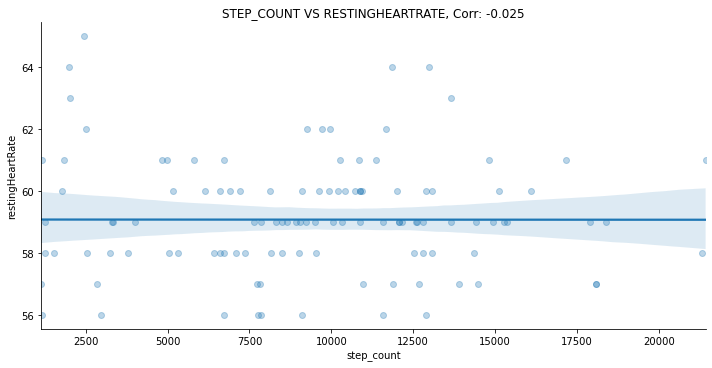

AFTER :



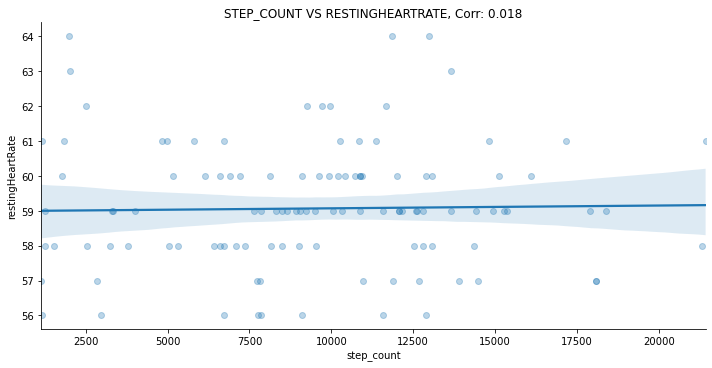


PERSON 2: 
BEFORE :



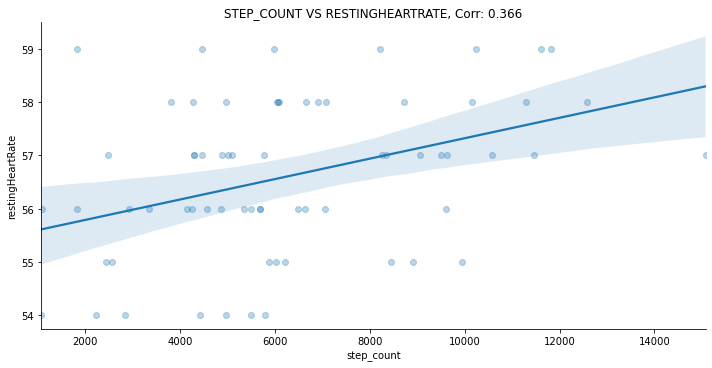

AFTER :



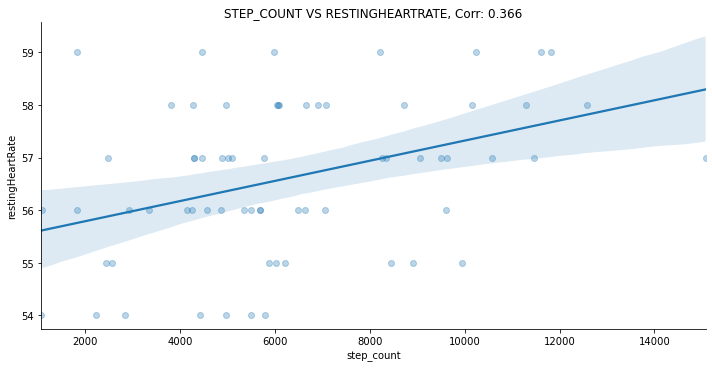

In [18]:
# Seaborn Scatter Plot for linear regression:

state = ['BEFORE','AFTER'] # words to print "xxx":

for i, DATA in enumerate(list_plot): # applying the same steps for PERSON1 and PERSON2.
    print('\nPERSON {}:'.format(i+1),'\n'+'='*10)
    
    for s in range(2):
        print(state[s],':\n')
        sns.lmplot(DATA[s].columns[0],DATA[s].columns[1],data=DATA[s],robust=True,aspect=2,scatter_kws={'alpha':0.3})

        # Finding Correlation:
        Corr_value = DATA[s].corr().iloc[0,1] # the .corr() method returns a matrix of corr values.
        plt.title(str(DATA[s].columns[0]).upper()+' VS '+str(DATA[s].columns[1]).upper()+', Corr: '+ str(round(Corr_value,3)))

        plt.show()


#### Using IQR to Exclude Outliers

In [19]:
# Excluding outliers (outside of 3*IQR)

list_plot = [] # define empt list to store DF for plotting later.

for i, subject in enumerate(PERSON_LIST): # applying the same steps for PERSON1 and PERSON2.
    print('\nPERSON {}:'.format(i+1),'\n'+'='*10)

    # INPUT X & Y SERIES:
    x_plot = subject.df_activity_steps.step_count.copy()
    y_plot = subject.df_resting_hr.restingHeartRate.copy()

    # Finding the inter-quantile range (IQR) between 25th and 75th percentile:

    # For X:
    X_Q1 = np.percentile(x_plot,25)
    X_Q3 = np.percentile(x_plot,75)
    X_IQR = X_Q3 - X_Q1
    print('IQR for {} = {}:\n25th percentile: {} \n75th percentile: {}'.format(x_plot.name,X_IQR,X_Q1, X_Q3))

    # For Y:
    Y_Q1 = np.percentile(y_plot,25)
    Y_Q3 = np.percentile(y_plot,75)
    Y_IQR = Y_Q3 - Y_Q1
    print('\nIQR for {} = {}:\n25th percentile: {} \n75th percentile: {}\n'.format(y_plot.name,Y_IQR,Y_Q1, Y_Q3))

    # Finding the points outside of 1.5*IQR from Q1 and Q3
    print("Outliers outside of 1.5*IQR from Q1 and Q3:")
    print("For X:\n", x_plot.loc[(x_plot < X_Q1-1.5*X_IQR) | (x_plot > X_Q3+1.5*X_IQR)])
    print("For Y:\n", y_plot.loc[(y_plot < Y_Q1-1.5*Y_IQR) | (y_plot > Y_Q3+1.5*Y_IQR)])

    new_x_plot = x_plot[(x_plot >= X_Q1-1.5*X_IQR) & (x_plot <= X_Q3+1.5*X_IQR)]
    new_y_plot = y_plot[(y_plot >= Y_Q1-1.5*Y_IQR) & (y_plot <= Y_Q3+1.5*Y_IQR)]

    # Match all points and Save into Dict to prep for Seaborn plotting:
    DATA_before = pd.concat([x_plot,y_plot],axis=1).dropna()
    DATA_after = pd.concat([new_x_plot,new_y_plot],axis=1).dropna()

    list_plot.append([DATA_before,DATA_after])


PERSON 1: 
IQR for step_count = 6092.75:
25th percentile: 6466.5 
75th percentile: 12559.25

IQR for restingHeartRate = 2.0:
25th percentile: 58.0 
75th percentile: 60.0

Outliers outside of 1.5*IQR from Q1 and Q3:
For X:
 Series([], Name: step_count, dtype: int32)
For Y:
 dateTime
2020-02-21    64.0
2020-05-09    64.0
2020-05-10    64.0
2020-05-11    65.0
Name: restingHeartRate, dtype: float64

PERSON 2: 
IQR for step_count = 3940.25:
25th percentile: 4416.5 
75th percentile: 8356.75

IQR for restingHeartRate = 2.0:
25th percentile: 56.0 
75th percentile: 58.0

Outliers outside of 1.5*IQR from Q1 and Q3:
For X:
 dateTime
2020-07-11    15080
Name: step_count, dtype: int32
For Y:
 Series([], Name: restingHeartRate, dtype: float64)



PERSON 1: 
BEFORE :



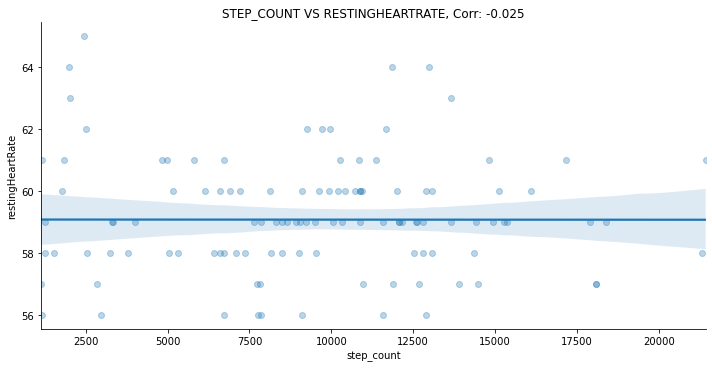

AFTER :



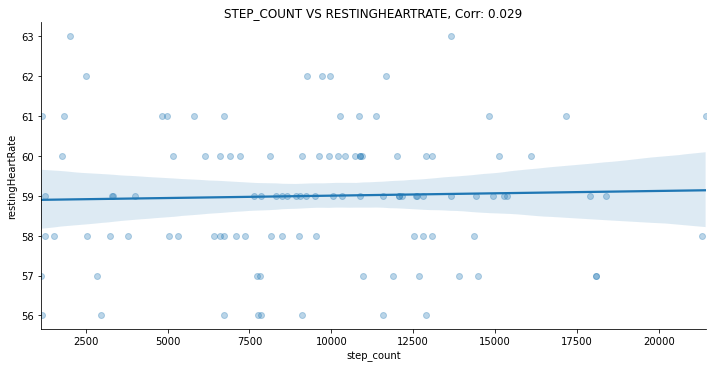


PERSON 2: 
BEFORE :



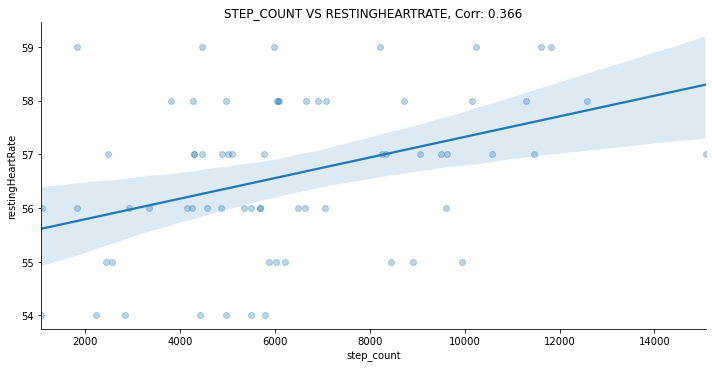

AFTER :



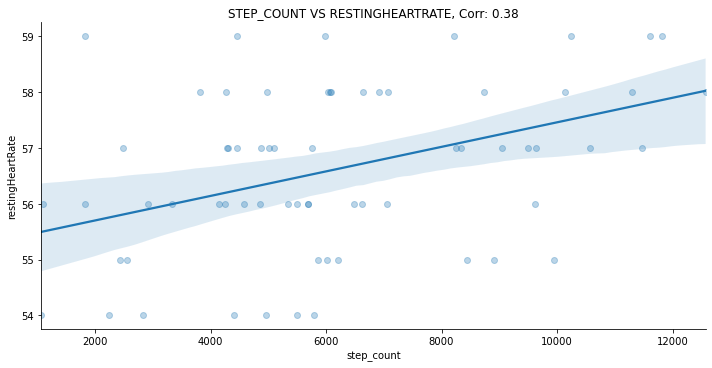

In [20]:
# Seaborn Scatter Plot for linear regression:

state = ['BEFORE','AFTER'] # words to print "xxx":

for i, DATA in enumerate(list_plot): # applying the same steps for PERSON1 and PERSON2.
    print('\nPERSON {}:'.format(i+1),'\n'+'='*10)
    
    for s in range(2):
        print(state[s],':\n')
        sns.lmplot(DATA[s].columns[0],DATA[s].columns[1],data=DATA[s],robust=True,aspect=2,scatter_kws={'alpha':0.3})

        # Finding Correlation:
        Corr_value = DATA[s].corr().iloc[0,1] # the .corr() method returns a matrix of corr values.
        plt.title(str(DATA[s].columns[0]).upper()+' VS '+str(DATA[s].columns[1]).upper()+', Corr: '+ str(round(Corr_value,3)))

        plt.show()


After excluding the outliers, the number of steps is positivily correlated to RHR for PERSON2 but no correlation with PERSON1. Both increased abit in the coefficient becoming positive.

### Difference between using IQR and Z-Score to find outliers

The difference between the above two methods is that IQR follows the percentiles which is not dependent on the "Shape" of distribution. Whereas Z-score calculates how many SD away a point is from the Mean value as the center value. Thus it may produce more outliers is the dataset is skewed to either side, it also means that the distribution has to be "Normal". In this case, using IQR would be better as the distribution may not be necessary Normal.

### NULL Hypothesis Test:

Null Hypothesis: The increase in number of steps taken would not cause a change in RHR value.

    H0: Correlation Coeff of Steps and RHR is close to 0 (Magnitude less than ref_val = 0.1)
    H1: Correlation Coeff not = 0 (More than 0.1)

We will use bootstrap replicate to repeat a bunch of time to get a better estimated value using the data from PERSON1 and PERSON2. The both data should not be combined and analysed as one big dataset as each person is different. The bootstrap will be used as to replicating observations of each person. Another reason we cant combine is because there were only data from 2 person, it is not representative of a general population.

In [21]:
def calc_correlations(x,y):
    df=pd.concat([pd.Series(x),pd.Series(y)],axis=1)
    return df.corr().iloc[0,1]

In [22]:
def draw_bs_pair_corr(x, y, size=1):
    """Perform pairs bootstrap for correlation."""

    # Set up array of indices to sample from: inds -> index
    inds = np.arange(0,len(x))

    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_corr_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds,len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_corr_reps[i] = calc_correlations(bs_x, bs_y)

    return bs_corr_reps


In [23]:
# DATASETS for PERSON1 & PERSON2

x_1 = PERSON1.df_activity_steps.step_count
y_1 = PERSON1.df_resting_hr.restingHeartRate

x_2 = PERSON2.df_activity_steps.step_count
y_2 = PERSON2.df_resting_hr.restingHeartRate

# merging the 2 dataframes x,y will produce NaN values if there is no record in the other column, 
# thus all records can be matched. -> pd.concat().dropna()
DATA1 = pd.concat([x_1,y_1],axis=1).dropna()
DATA2 = pd.concat([x_2,y_2],axis=1).dropna()


In [24]:
# BOOTSTRAP REPLICATE

n_rep = 10000 # Number of replicates

corr_rep1 = draw_bs_pair_corr(DATA1['step_count'],DATA1['restingHeartRate'],n_rep)
corr_rep2 = draw_bs_pair_corr(DATA2['step_count'],DATA2['restingHeartRate'],n_rep)

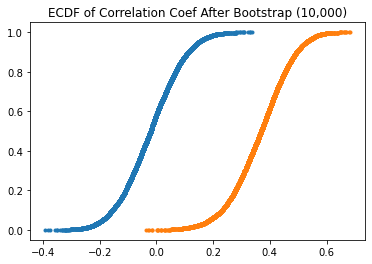

In [25]:
# PLOTITING OUT THE ECDF:

x_point1,y_point1 = ecdf(corr_rep1)
x_point2,y_point2 = ecdf(corr_rep2)

plt.plot(x_point1,y_point1,'.')
plt.plot(x_point2,y_point2,'.')

plt.title("ECDF of Correlation Coef After Bootstrap (10,000)")

plt.show()

In [26]:
print("PERSON 1:")
print("The correlation value calculate from the dataset:",DATA1.corr().iloc[0,1])
print("The correlation value calculate from the bootstrap:",np.mean(corr_rep1))
print("Standard Error: -+",np.std(corr_rep1))
print("95% Confidence Interval between:",np.percentile(corr_rep1,[2.5,97.5]))

print("\nPERSON 2:")
print("The correlation value calculate from the dataset:",DATA2.corr().iloc[0,1])
print("The correlation value calculate from the bootstrap:",np.mean(corr_rep2))
print("Standard Error: -+",np.std(corr_rep2))
print("95% Confidence Interval between:",np.percentile(corr_rep2,[2.5,97.5]))


PERSON 1:
The correlation value calculate from the dataset: -0.024864872294718586
The correlation value calculate from the bootstrap: -0.020608876530426017
Standard Error: -+ 0.10309255343505423
95% Confidence Interval between: [-0.21852314  0.18101605]

PERSON 2:
The correlation value calculate from the dataset: 0.36620220725292213
The correlation value calculate from the bootstrap: 0.3650918687931731
Standard Error: -+ 0.1034125291636772
95% Confidence Interval between: [0.15165327 0.5560604 ]


From the above, for PERSON 2, the number of steps is positively correlated with the RHR after 10,000 replications. the correlation will be positive, from 0.15 to 0.55, 95% of the time.

Whereas for PERSON 1, the correlation is almost negligible.

In [27]:
# P-VALUE

# REFERENCE VALUE FOR CORRELATION:
ref_val = 0.1 # assuming correlation is insignificant when its magnitude is lesser than 0.1

pval = np.sum(np.abs(corr_rep1) < ref_val)/len(corr_rep1)
print('PERSON 1:\n p-val =',pval)

pval = np.sum(np.abs(corr_rep2) < ref_val)/len(corr_rep2)
print('\nPERSON 2:\n p-val =',pval)

PERSON 1:
 p-val = 0.6511

PERSON 2:
 p-val = 0.0086


In PERSON 2, the p-value (0.0099) is able rejects the null hypothesis while unable for PERSON 1 (0.655). The correlation of Steps and RHR may be very weak. It shows positive correlations in a person and none for the other.

Back to the Hypothesis, the lower the RHR, the healthier a person. The Positive correlation did not not show that as number of steps increase, the heart health will improve.

### Other Tests For Correlations

#### Pecentage Changes Comparison

By using .pct_change(), we are able to get percentage changes between each record (changes per day).


PERSON 1: 


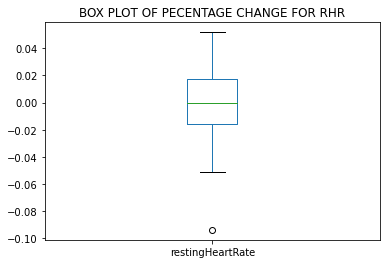

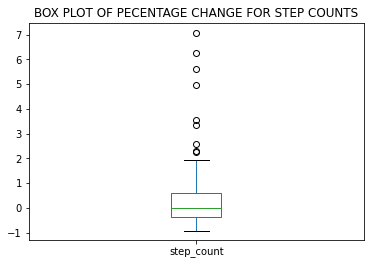


PERSON 2: 


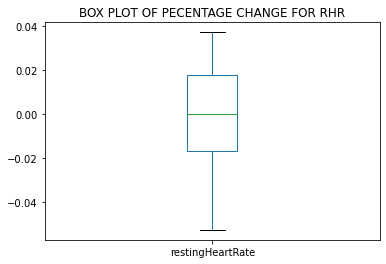

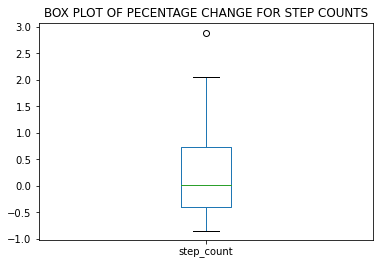

In [28]:
# Using Percentage Change (with IQR to exclude outliers)

for i, subject in enumerate(PERSON_LIST): # applying the same steps for PERSON1 and PERSON2.
    print('\nPERSON {}:'.format(i+1),'\n'+'='*10)

    rhr_pct_change = subject.df_resting_hr.restingHeartRate.sort_index().pct_change()
    steps_pct_change = subject.df_activity_steps.step_count.reindex(rhr_pct_change.index).pct_change()

    # Viewing outliers in Box Plot:
    DATA = pd.concat([steps_pct_change,rhr_pct_change],axis=1)
    DATA['restingHeartRate'].plot(kind='box')
    plt.title('BOX PLOT OF PECENTAGE CHANGE FOR RHR')
    plt.show()

    DATA['step_count'].plot(kind='box')
    plt.title('BOX PLOT OF PECENTAGE CHANGE FOR STEP COUNTS')
    plt.show()



PERSON 1: 


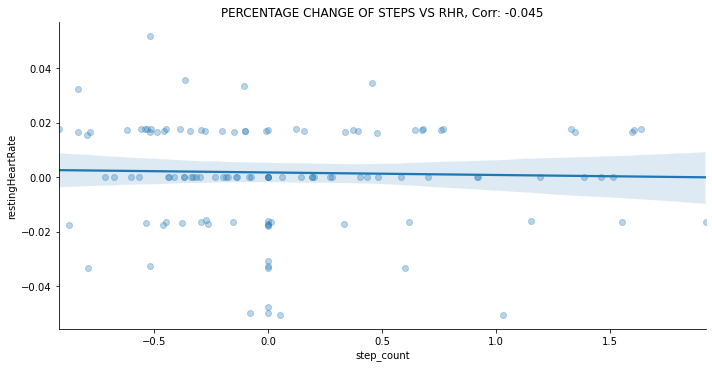


PERSON 2: 


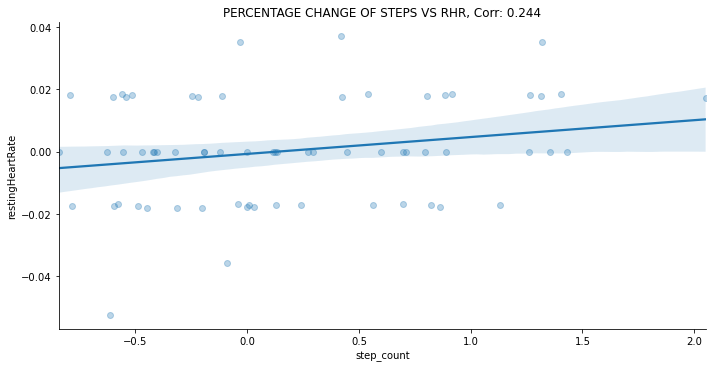

In [29]:
# Using Percentage Change to compare (with IQR to exclude outliers)
DATA_list = []

for i, subject in enumerate(PERSON_LIST): # applying the same steps for PERSON1 and PERSON2.
    print('\nPERSON {}:'.format(i+1),'\n'+'='*10)

    rhr_pct_change = subject.df_resting_hr.restingHeartRate.sort_index().pct_change().dropna()
    steps_pct_change = subject.df_activity_steps.step_count.reindex(rhr_pct_change.index).pct_change().dropna()

    # Finding IQR
    # For X:
    X_Q1 = np.percentile(steps_pct_change,25)
    X_Q3 = np.percentile(steps_pct_change,75)
    X_IQR = X_Q3 - X_Q1

    # For Y:
    Y_Q1 = np.percentile(rhr_pct_change,25)
    Y_Q3 = np.percentile(rhr_pct_change,75)
    Y_IQR = Y_Q3 - Y_Q1

    # Excluding the outliers in Steps:
    steps_pct_change = steps_pct_change[(steps_pct_change >= X_Q1-1.5*X_IQR) & (steps_pct_change <= X_Q3+1.5*X_IQR)]
    rhr_pct_change = rhr_pct_change[(rhr_pct_change >= Y_Q1-1.5*Y_IQR) & (rhr_pct_change >= Y_Q1-1.5*Y_IQR)]

    # Plotting:
    DATA = pd.concat([steps_pct_change,rhr_pct_change],axis=1)
    DATA_list.append(DATA)
    sns.lmplot(DATA.columns[0],DATA.columns[1],data=DATA,robust=True,aspect=2,scatter_kws={'alpha':0.3})

    # Finding Correlation:
    Corr_value = DATA.corr().iloc[0,1] # .corr() method returns a matrix of corr values.
    plt.title('PERCENTAGE CHANGE OF STEPS VS RHR, Corr: '+ str(round(Corr_value,3)))

    plt.show()


In [30]:
# BOOTSTRAP REPLICATE
n_rep = 10000 # Number of replicates

for i, subject in enumerate(PERSON_LIST): # applying the same steps for PERSON1 and PERSON2.
    print('\nPERSON {}:'.format(i+1),'\n'+'='*10)

    corr_rep = draw_bs_pair_corr(DATA_list[i]['step_count'],DATA_list[i]['restingHeartRate'],n_rep)

    print("The correlation value calculate from the dataset:",DATA_list[i].corr().iloc[0,1])
    print("The correlation value calculate from the bootstrap:",np.mean(corr_rep))
    print("Standard Error: -+",np.std(corr_rep))
    print("95% Confidence Interval between:",np.percentile(corr_rep,[2.5,97.5]))


PERSON 1: 
The correlation value calculate from the dataset: -0.044825254059485425
The correlation value calculate from the bootstrap: -0.045955102443014345
Standard Error: -+ 0.08548663159584995
95% Confidence Interval between: [-0.21319266  0.12026085]

PERSON 2: 
The correlation value calculate from the dataset: 0.24413710481494802
The correlation value calculate from the bootstrap: 0.23922545273571813
Standard Error: -+ 0.10928139382556133
95% Confidence Interval between: [0.01488495 0.44233783]


### Very Active Duration VS RHR

In [31]:
VeryActive_col = ['minutes_Cardio', 'minutes_Peak']



PERSON 1: 


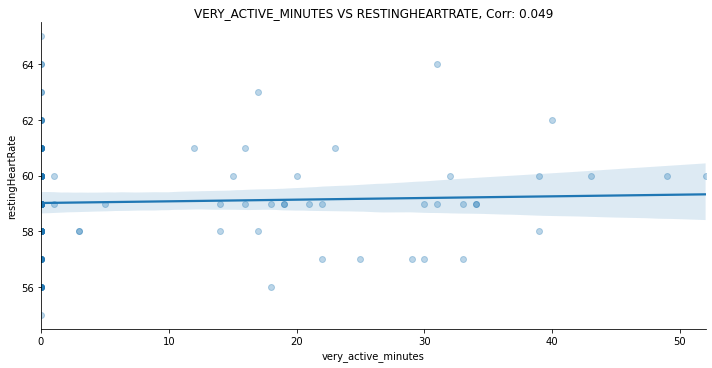


PERSON 2: 


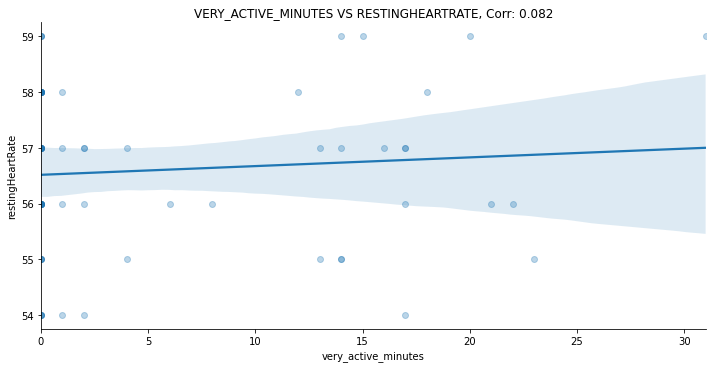

In [50]:
# Calculating the total duartion when HR is in Peak & Cardio Levels (very active / High HeartRate)

for i, subject in enumerate(PERSON_LIST):
    print('\nPERSON {}:'.format(i+1),'\n'+'='*10)
    df_process = pd.DataFrame({'very_active_minutes':subject.df_hr_calories[VeryActive_col].sum(axis=1)})
    df_process.index.name = 'date'

    DATA = pd.concat([df_process,subject.df_resting_hr.restingHeartRate.sort_index()],axis=1)

    sns.lmplot(DATA.columns[0],DATA.columns[1],data=DATA,robust=True,aspect=2,scatter_kws={'alpha':0.3})

    # Finding Correlation:
    Corr_value = DATA.corr().iloc[0,1] # the .corr() method returns a matrix of corr values.
    plt.title(str(DATA.columns[0]).upper()+' VS '+str(DATA.columns[1]).upper()+', Corr: '+ str(round(Corr_value,3)))

    plt.show()

In [51]:
# Function for Standardisation of Dataset:

from sklearn import preprocessing

def Standardise(df):
    
    # Standardising the dataset (Mean = 0, SD =1):
    scaler = preprocessing.StandardScaler()
    scaled_df = scaler.fit_transform(df)
    scaled_df = pd.DataFrame(scaled_df, columns=df.columns)    
    
    return scaled_df


PERSON 1: 


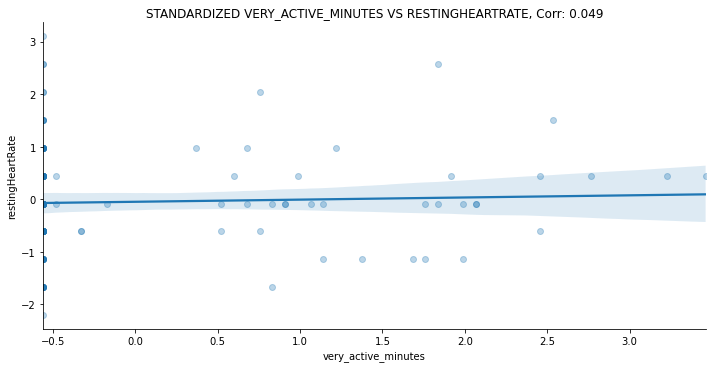


PERSON 2: 


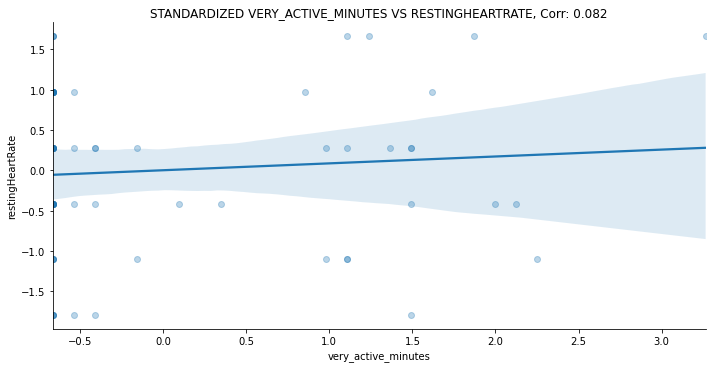

In [52]:
# STANDARDISING THE DATA:

# Calculating the total duartion when HR is in Peak & Cardio Levels (very active / High HeartRate)

for i, subject in enumerate(PERSON_LIST):
    print('\nPERSON {}:'.format(i+1),'\n'+'='*10)
    df_process = pd.DataFrame({'very_active_minutes':subject.df_hr_calories[VeryActive_col].sum(axis=1)})
    df_process.index.name = 'date'
    
    x_plot = df_process.sort_index()
    y_plot = subject.df_resting_hr.restingHeartRate.sort_index()

    DATA = pd.concat([x_plot, y_plot],axis=1)
    DATA = Standardise(DATA.dropna())

    sns.lmplot(DATA.columns[0],DATA.columns[1],data=DATA,robust=True,aspect=2,scatter_kws={'alpha':0.3})

    # Finding Correlation:
    Corr_value = DATA.corr().iloc[0,1] # the .corr() method returns a matrix of corr values.
    plt.title("STANDARDIZED " +str(DATA.columns[0]).upper()+' VS '+str(DATA.columns[1]).upper()+', Corr: '+ str(round(Corr_value,3)))

    plt.show()

In summary, the data gather showed positive correlation between RHR and Number of steps. Disproving the expected hypothesis. In PERSON1, the 95 percent CI shows that there are potentially negative correlations.

Futhermore, there seems to be negligible relationship between Duration in Very Active (Peak and Cardio) HR Zones with the RHR.

This paper concludes that RHR is a indicator for Mortality. https://heart.bmj.com/content/99/12/882
FITBIT also did a study and suggests that an increase in the amount of exercise (best about 150 mins per week) can lower the RHR. https://www.digitaltrends.com/health-fitness/fitbit-resting-heart-rate-study/ 

Perhaps the number of steps might not be the best indicator in representing the active level of a person.